# Damping model with one degree of freedom

In this example of one degree of freedom with damping, we use here python interface, translate this program for another interface or in C++ is easy.

## The probelm setting

A single truss element is used to verify the damping of a single-degree-of-freedom system.
Node 1 is fully constrained, and the damped free vibration is obtained after giving an instantaneous forced displacement of 1 mm in the $x$ direction of node 2.

## Building the program
Let us begin by loading GetFEM and fixing the parameter of the problem.

In [ ]:
import getfem as gf
import numpy as np

E = 1.0E+05   # Young Modulus (N/mm^2)
rho = 8.9E-09 # Mass Density (ton/mm^3)
A = 1.0       # Cross-Sectional Area (mm^2)
L = 1000.0    # Length (mm)

### Mesh generation
We consider that the length of mesh is 1D and it has 1 convex.
We generate the mesh of the one degree of freedom using empty mesh of GetFEM (see the documentation of the Mesh object in the python interface).

In [ ]:
m = gf.Mesh("empty", 1)
cvid = m.add_convex(gf.GeoTrans("GT_PK(1, 1)"), [[0, L]])

We can check the mesh information using print function.
We can see that the mesh has 2 point and 1 convex.

In [3]:
print(m)


BEGIN POINTS LIST

  POINT COUNT 2
  POINT  0  0
  POINT  1  1000

END POINTS LIST



BEGIN MESH STRUCTURE DESCRIPTION

  CONVEX COUNT 1
  CONVEX 0    'GT_PK(1,1)'      0  1

END MESH STRUCTURE DESCRIPTION



If you want to build a regular mesh quickly with multi convexs, you can use following Mesh object constructor.

In [4]:
m = gf.Mesh("cartesian", [0, L])

In [5]:
print(m)


BEGIN POINTS LIST

  POINT COUNT 2
  POINT  0  0
  POINT  1  1000

END POINTS LIST



BEGIN MESH STRUCTURE DESCRIPTION

  CONVEX COUNT 1
  CONVEX 0    'GT_PK(1,1)'      0  1

END MESH STRUCTURE DESCRIPTION



We can exports a mesh to a VTK file .

In [6]:
m.export_to_vtk("m.vtk")

The result is the following.

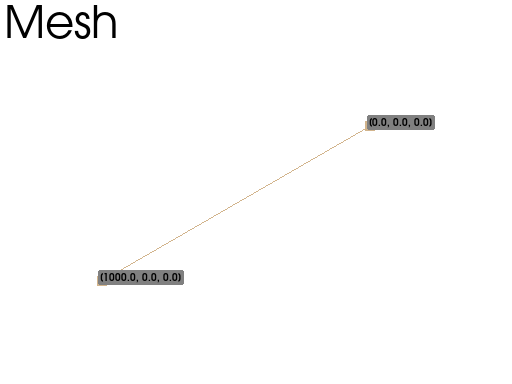

In [7]:
import pyvista as pv
from pyvirtualdisplay import Display
import os
display = Display(visible=0, size=(1280, 1024))
display.start()
plotter = pv.Plotter()
mesh = pv.read("m.vtk")
plotter.add_mesh(mesh)
plotter.add_text("Mesh", "upper_left")
points = mesh.points
plotter.add_point_labels(points, points.tolist(), point_size=10, font_size=10)
plotter.show(window_size=[512, 384])
display.stop()

### Boundary selection
We have to select the different parts of the boundary where we will set some boundary conditions, namely boundary of the fix boundary $(0.0, 0.0, 0.0)$ and the deformed boundary $(1000.0, 0.0, 0.0)$.

In [8]:
fb1 = m.outer_faces_with_direction([-1.], 0.01)
fb2 = m.outer_faces_with_direction([1.], 0.01)

FIX_BOUNDARY = 1
DEFORMED_BOUNDARY = 2

m.set_region(FIX_BOUNDARY, fb1)
m.set_region(DEFORMED_BOUNDARY, fb2)

In [9]:
print(m)


BEGIN POINTS LIST

  POINT COUNT 2
  POINT  0  0
  POINT  1  1000

END POINTS LIST



BEGIN MESH STRUCTURE DESCRIPTION

  CONVEX COUNT 1
  CONVEX 0    'GT_PK(1,1)'      0  1

END MESH STRUCTURE DESCRIPTION
BEGIN REGION 1
0/1 
END REGION 1
BEGIN REGION 2
0/0 
END REGION 2

